<a href="https://colab.research.google.com/github/AmritSDutta/colab_ml/blob/main/audio_speech_command_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torchaudio
import IPython.display as ipd
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F

In [4]:
DATASET_ROOT = 'sample_data'
train_dataset = torchaudio.datasets.SPEECHCOMMANDS(
        root=DATASET_ROOT,
        url="speech_commands_v0.02", # Specify the version of the dataset
        download=True,
        subset="training"
    )
    # Use subset="testing" for the test split
test_dataset = torchaudio.datasets.SPEECHCOMMANDS(
        root=DATASET_ROOT,
        url="speech_commands_v0.02",
        download=True,
        subset="testing"
    )
print("SpeechCommands dataset loaded successfully!")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")


SpeechCommands dataset loaded successfully!
Number of training samples: 84843
Number of testing samples: 11005


In [5]:
train_dataset.get_metadata(5)

('speech_commands_v0.02/backward/017c4098_nohash_4.wav',
 16000,
 'backward',
 '017c4098',
 4)

In [6]:
all_labels_list = [train_dataset.get_metadata(i)[2] for i in range(len(train_dataset))]
unique_labels_sorted = sorted(set(all_labels_list))
print(unique_labels_sorted)
print(f"Total unique labels: {len(unique_labels_sorted)}")

['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']
Total unique labels: 35


In [7]:
label_to_id: dict[str, int] = {label: idx for idx, label in enumerate(unique_labels_sorted)}
id_to_label: dict[int, str] = {idx: label for idx, label in enumerate(unique_labels_sorted)}

In [8]:
waveform, sample_rate, label, speaker_id, utterance_number = train_dataset[0]
print(f"Waveform shape: {waveform.shape}")
print(f"Sample rate: {sample_rate}")
print(f"Label: {label}")



Waveform shape: torch.Size([1, 16000])
Sample rate: 16000
Label: backward


In [9]:
ipd.Audio(waveform.numpy(), rate=sample_rate)

prepare dataloader , but preprocess with sample rate, duration, pad or trim, possible create spectogram

In [10]:
def transformation(batch):
    """
    Collation function to process batch samples.
    Converts string labels to numerical IDs and applies transforms.
    """
    waveforms = []
    labels_numerical = []

    # Unpack the batch and prepare for processing
    # Each 'item' in batch is (waveform, sample_rate, label_str, speaker_id, utterance_number)
    for waveform, sample_rate, label, speaker_id, utterance_number in batch:
        if waveform.ndim == 1:
          waveform = waveform.unsqueeze(0) # Add a channel dimension
        frames = waveform.shape[-1]
        duration = frames/ sample_rate
        if duration < 1.0:
            padding_needed = sample_rate - frames
            waveform_original = torch.nn.functional.pad(waveform, (0, padding_needed))
        elif duration > 1.0:
            waveform_original = waveform[:, :sample_rate]
        else:
            waveform_original = waveform

        # Apply audio transformation (e.g., padding/trimming)
        processed_waveform = waveform_original
        waveforms.append(processed_waveform)

        # Convert string label to numerical ID (the target for our model)
        labels_numerical.append(label_to_id[label])

    # Stack waveforms and labels into batch tensors
    # Waveforms should be (batch_size, channels, num_samples)
    # Labels should be (batch_size) and of type torch.long
    batch_waveforms = torch.stack(waveforms)
    batch_labels = torch.tensor(labels_numerical, dtype=torch.long)

    return batch_waveforms, batch_labels

In [17]:
dataloader_train = DataLoader(dataset = train_dataset, batch_size=512, shuffle = True, collate_fn=transformation)
dataloader_test = DataLoader(dataset = test_dataset, batch_size=512, shuffle = True, collate_fn=transformation)

Waveform batch shape: torch.Size([512, 1, 201, 81])
Label batch: tensor([23,  4, 20, 17, 34, 10, 15, 18, 12, 34,  3,  7, 30, 23, 27,  0,  3, 24,
        15, 31, 34, 34,  6, 16, 17, 25,  5, 17, 23, 10,  7, 34, 21, 15, 20, 15,
        17, 30, 32, 15, 11, 18, 20,  3,  8, 21, 18, 34, 25, 15, 15, 28, 10, 17,
         5,  5, 29, 34, 27, 30,  2, 19, 25, 21, 25, 26,  1, 27, 10, 23, 27, 15,
         5,  1, 13, 27,  6, 25, 33, 34, 13,  0, 30, 32,  2, 28, 24,  6, 31, 26,
        11, 16, 27, 34, 21, 22, 30, 31, 31, 17, 27, 19, 25,  5, 25, 16, 24, 33,
         1, 19,  9, 34, 16, 18, 30, 27, 11, 26, 21, 22,  6, 28, 33, 21, 28, 29,
        21, 31,  7, 28, 19, 18, 15, 10, 23, 22,  8, 29, 33,  5, 34, 10, 21, 11,
         6,  2, 27, 27, 21, 20, 16, 29, 22,  5,  2, 16,  5, 25, 16, 25, 16, 11,
        11, 19, 21, 31,  0, 22,  8, 34,  4,  9, 18, 34, 26,  2, 29, 15,  2, 15,
        11, 33, 19, 20,  2, 32, 29, 30, 11, 18, 21, 33, 18, 29, 13, 28,  8, 34,
        25,  6, 30, 18,  7, 10, 33, 14, 29, 14, 10, 26,

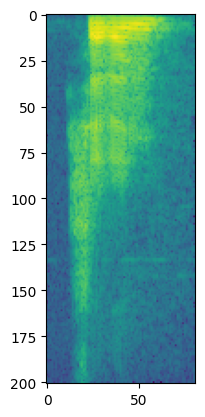

In [30]:
import matplotlib.pyplot as plt
wav, label = next(iter(dataloader_train))
spectogram =torchaudio.transforms.Spectrogram()(wav)
print(f"Waveform batch shape: {spectogram.shape}")
print(f"Label batch: {label}")
print("Shape of spectrogram: {}".format(spectogram.size()))

plt.figure()
plt.imshow(spectogram.squeeze(0,1).log2()[0,:,:].numpy())

In [22]:
import torch
import torch.nn as nn

class AudioClassifierModule(nn.Module):
  def  __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.convolution = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=80, padding=1),
            nn.BatchNorm1d(32),
            nn.MaxPool1d(4),
            nn.ReLU(),
            nn.Conv1d(32, 16, kernel_size=40, padding=1),
            nn.BatchNorm1d(16),
            nn.MaxPool1d(4),
            nn.ReLU(),
            nn.Conv1d(16, 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(4),
            nn.MaxPool1d(4),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4 *246 , 64), # Corrected input size for linear layer
            nn.ReLU(),
            nn.Dropout(0.05),
            nn.Linear(64, 35),
        )


  def forward(self, x):
        x = self.convolution(x)
        x = self.classifier(x)
        return x

In [23]:
# cross check quickly
model = AudioClassifierModule()
dummy_spectogram = torch.randn(1, 1, 16000)
output = model(dummy_spectogram)
assert output.shape == (1, 35)

In [24]:
print(model)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)


AudioClassifierModule(
  (convolution): Sequential(
    (0): Conv1d(1, 32, kernel_size=(80,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Conv1d(32, 16, kernel_size=(40,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): Conv1d(16, 4, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=984, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.0

In [26]:
import torch.nn.functional as F
from torch.utils.data import Subset

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)

def evaluate(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():  # Disable gradient calculation
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            y_pred_log = F.log_softmax(y_pred, dim=1)  # Apply log_softmax to the output
            loss = F.nll_loss(y_pred_log.squeeze(), y)
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(y_pred.data, 1)
            total_samples += y.size(0)
            correct_predictions += (predicted == y).sum().item()

    average_loss = total_loss / len(dataloader)
    accuracy = 100 * correct_predictions / total_samples
    return average_loss, accuracy

def train(model, train_dataloader, val_dataloader, optimizer, device, epochs):
    model.train() # set model to train mode
    print(f'No. of Training Batches: {len(train_dataloader)}')
    print(f'No. of Validation Batches: {len(val_dataloader)}')

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n-----------------------------")
        for batch, (x, y) in enumerate(train_dataloader):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            y_pred_log = F.log_softmax(y_pred, dim=1)  # Apply log_softmax to the output
            loss = F.nll_loss(y_pred_log.squeeze(), y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (batch + 1) % 50 == 0:
                loss, current = loss.item(), (batch +1) * len(x)
                print(f"Train loss: {loss:>7f}  [{current:>5d}/{len(train_dataloader.dataset)}]")


        # Evaluate on the validation set after each epoch
        val_loss, val_accuracy = evaluate(model, val_dataloader, device)
        print(f"Epoch {epoch+1} Validation Loss: {val_loss:>7f}, Validation Accuracy: {val_accuracy:>3f}%\n")


# Create a new dataloader for the validation subset
dataloader_val = DataLoader(dataset=test_dataset, batch_size=512, shuffle=True, collate_fn=transformation)

# Use the new validation dataloader in the train function
train(model, dataloader_train, dataloader_val, optim, device, 10)

No. of Training Batches: 166
No. of Validation Batches: 22
Epoch 1
-----------------------------
Train loss: 2.617486  [  561/84843]
Train loss: 2.234358  [  611/84843]
Train loss: 2.163029  [  661/84843]
Epoch 1 Validation Loss: 3.469751, Validation Accuracy: 20.181736%

Epoch 2
-----------------------------
Train loss: 2.840868  [  561/84843]
Train loss: 2.589446  [  611/84843]
Train loss: 2.643961  [  661/84843]
Epoch 2 Validation Loss: 2.375565, Validation Accuracy: 29.831895%

Epoch 3
-----------------------------
Train loss: 2.039996  [  561/84843]
Train loss: 2.191508  [  611/84843]
Train loss: 2.066612  [  661/84843]
Epoch 3 Validation Loss: 2.046166, Validation Accuracy: 39.582008%

Epoch 4
-----------------------------
Train loss: 1.926820  [  561/84843]
Train loss: 1.820535  [  611/84843]
Train loss: 1.674348  [  661/84843]
Epoch 4 Validation Loss: 1.651362, Validation Accuracy: 51.367560%

Epoch 5
-----------------------------
Train loss: 1.586002  [  561/84843]
Train loss: